<a href="https://colab.research.google.com/github/chen-star/llm_model_trainings/blob/main/train_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Neural Language Model

This notebook demonstrates training a **Neural Language Model** to learn **Word Embeddings**, based on the seminal work by *Bengio et al. (2003)*.

### 🎯 Goal
The objective is to learn a dense vector representation (embedding) for each word in the vocabulary. These embeddings capture semantic meaning, where words with similar meanings are close in the vector space.

### 🏗️ Architecture

![Embedding Model Architecture](assets/embedding_model_architecture.png)

The model predicts the **next word** in a sequence given a fixed-size context window of previous words.

$$P(w_t | w_{t-n+1}, ..., w_{t-1})$$

#### 📊 Architecture Details

1.  **Input Indices**
    *   **Input**: Batch of context word indices $(B, n)$.
    *   **Output**: Same indices.
    *   **Meaning**: The sequence of $n$ words preceding the target word.

2.  **Embedding Lookup**
    *   **Input**: Word indices.
    *   **Output**: Word vectors $(B, n, D)$.
    *   **Meaning**: Converting discrete words into dense semantic vectors.

3.  **Concatenation**
    *   **Input**: List of $n$ vectors.
    *   **Output**: Single flattened vector $(B, n \times D)$.
    *   **Meaning**: Combining context information into a single feature vector.

4.  **Hidden Layer**
    *   **Input**: Flattened vector.
    *   **Output**: Hidden state $(B, H)$.
    *   **Meaning**: Learning non-linear feature interactions (using ReLU).

5.  **Output Layer**
    *   **Input**: Hidden state.
    *   **Output**: Logits/Probabilities $(B, V)$.
    *   **Meaning**: Predicting the likelihood of the next word in the vocabulary.
#### Visualizing Embeddings
Ideally, the trained embeddings will organize words in the vector space such that semantically similar words are close together, and spatial relationships capture analogies.

![Embedding Space Visualization](assets/embedding_space_visualization.png)


### 🧠 Example Walkthrough

Let's trace a single training example with small dimensions to make the data flow concrete.

**Scenario Setup:**
*   **Vocabulary**: `["the", "cat", "sits", "on", "mat"]` ($V=5$)
*   **Context Window**: $n=3$
*   **Embedding Dimension**: $D=2$
*   **Hidden Size**: $H=4$
*   **Input Sequence**: `"the cat sits"` $\rightarrow$ Target: `"on"`

---

#### 1. Input Layer
*   **Input**: Indices for `["the", "cat", "sits"]`
*   **Tensor**: `[0, 1, 2]`
*   **Shape**: `(1, 3)`

#### 2. Embedding Lookup
*   **Operation**: Retrieve vectors for indices 0, 1, 2.
*   **Hypothetical Vectors**:
    *   "the" (0): `[0.1, 0.2]`
    *   "cat" (1): `[0.3, 0.4]`
    *   "sits" (2): `[0.5, 0.6]`
*   **Output**: `[[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]]`
*   **Shape**: `(1, 3, 2)`

#### 3. Concatenation (Flatten)
*   **Operation**: Concatenate all context vectors into one long feature vector.
*   **Output**: `[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]`
*   **Shape**: `(1, 6)` (where $6 = n \times D$)

#### 4. Hidden Layer
*   **Operation**: Matrix multiplication ($W_1 \cdot x + b_1$) followed by ReLU.
*   **Hypothetical Result**: `[0.8, 0.0, 0.5, 1.2]`
*   **Shape**: `(1, 4)` (where $4 = H$)

#### 5. Output Layer
*   **Operation**: Matrix multiplication ($W_2 \cdot h + b_2$) to project to vocabulary size.
*   **Hypothetical Logits**: `[1.2, -0.5, 0.1, 2.5, 0.3]`
*   **Shape**: `(1, 5)` (where $5 = V$)

#### 6. Prediction & Loss
*   **Prediction**: The highest logit is `2.5` at index **3**.
*   **Mapping**: Index 3 corresponds to **"on"**.
*   **Result**: The model correctly predicts the next word!
*   **Training**: We calculate Cross Entropy Loss against the true target (index 3) and backpropagate to update the weights and embeddings.

# ✈ Imports

In [79]:
# Core libs for numerical operations and plotting
import numpy as np
from typing import override
import matplotlib.pyplot as plt
import matplotlib as mpl

# Libraries for text processing
import requests
import re
import string

# PyTorch specific libraries
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

# External library for model summary and visualization
!pip install torchinfo # not installed by default in colab
from torchinfo import summary

# Matplotlib inline backend settings
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# huggingface
from datasets import load_dataset

# [0] 📁 Download Wiki Text and Tokenization

* Download dataset from huggingface dataset `Salesforce/wikitext`

* Sample 10k wiki text and tokenize to create vocabulary lookup-table.

In [80]:
ds = load_dataset("Salesforce/wikitext", "wikitext-103-v1")


In [81]:
import re
import string

sample_size = 10000
all_text_sample = " ".join(ds['train']['text'][:sample_size])

# Split based on whitespace and punctuation
raw_words = re.split(r'[\s{}]+'.format(re.escape(string.punctuation)), all_text_sample)

# Filter out strings with length <= 1 and tokens with special characters
words = [
    word.strip().lower() for word in raw_words
    if len(word.strip()) > 1 and re.fullmatch(r'[a-zA-Z]+', word)
]

# Create vocabulary (unqiue set of words)
vocabulary = sorted(set(words))
numWords = len(words)
vocabulary_size = len(vocabulary)

# Encode / Decode tables. (Token_text <-> Token_ID)
token2id = {token: idx for idx, token in enumerate(vocabulary)}
id2Token = {idx : token for idx, token in enumerate(vocabulary)}


print(f'** This imported wiki dataset contains {numWords} words.')
print(f'** The vocabulary contains {vocabulary_size} unique words (tokens).\n')
print(f'** The first 10 words are: \n {list(words)[:10]} \n')
print(f'** The first 10 tokens are: \n {list(token2id.items())[:10]} \n')

** This imported wiki dataset contains 436368 words.
** The vocabulary contains 27991 unique words (tokens).

** The first 10 words are: 
 ['valkyria', 'chronicles', 'iii', 'no', 'valkyria', 'unk', 'chronicles', 'japanese', 'lit', 'valkyria'] 

** The first 10 tokens are: 
 [('aa', 0), ('aaa', 1), ('aadt', 2), ('aaj', 3), ('aak', 4), ('aaknal', 5), ('aamir', 6), ('aap', 7), ('aapke', 8), ('aaron', 9)] 



# [1] 🗄 Create Dataset and DataLoader

In [82]:
class TokenDataset(Dataset):
    def __init__(self, word_list, word_to_id, context_window_size=6, stride=4):
        self.word_to_id = word_to_id
        self.inputs = []
        self.targets = []

        # Example of how input and target sequences are formed:
        # Original text: "Training a toy embedding model requires data that is clean and rich in context"
        # If window_size is 6, stride is 4:
        # input[0]:  ["Training", "a", "toy", "embedding", "model", "requires"]
        # target[0]: ["a", "toy", "embedding", "model", "requires", "data"]
        # input[1]:  ["model", "requires", "data", "that", "is", "clean"]
        # target[1]: ["requires", "data", "that", "is", "clean", "and"]
        # ...

        # Iterate through the word list to create input-target pairs
        # The loop stops early to ensure a full window_size target sequence can be formed.
        for i in range(0, len(word_list) - context_window_size, stride):
          # Input:  [w_t, w_{t+1}, ..., w_{t+n-1}]
          input_sequence_text = word_list[i : i + context_window_size]
          
          # Target: [w_{t+1}, ..., w_{t+n}]
          # We only strictly need the last word w_{t+n} for the loss, but we store the whole sequence 
          # for debugging or if we wanted to predict multiple steps.
          target_sequence_text = word_list[i + 1 : i + context_window_size + 1]

          input_sequence_ids = [word_to_id[word] for word in input_sequence_text]
          target_sequence_ids = [word_to_id[word] for word in target_sequence_text]

          self.inputs.append(torch.tensor(input_sequence_ids))
          self.targets.append(torch.tensor(target_sequence_ids))

    @override
    # Returns the total number of input-target pairs.
    def __len__(self):
      """Returns the total number of input-target pairs in the dataset."""
      return len(self.inputs)

    @override
    def __getitem__(self, index):
        """Returns the input and target tensors for a given index."""
        return self.inputs[index], self.targets[index]

# Initialize the dataset using the cleaned 'words' list and the 'token2id' mapping
wiki_text_dataset = TokenDataset(word_list=words, word_to_id=token2id, context_window_size=6, stride=3)

# Example: Retrieve the last item from the dataset
wiki_text_dataset[-1]

(tensor([19445, 17353, 25284, 25098, 19780, 13079]),
 tensor([17353, 25284, 25098, 19780, 13079,  7448]))

In [83]:
batch_size = 2 # 2 is easy for viewing the training process

dataloader = DataLoader(
      wiki_text_dataset,
      batch_size=batch_size,
      shuffle=True,   # shuffle each epoch
      drop_last=True, # drop incomplete batch
    )

# View inputs and targets
first_batch_inputs, first_batch_targets = next(iter(dataloader))
print(f'** 1st batch inputs shape: {first_batch_inputs.shape}, targets shape: {first_batch_targets.shape}')
print(f'** 1st input in 1st batch: \n {first_batch_inputs[0]}. ')
print(f'** 1st input in 1st batch: \n {first_batch_inputs[0]} = {[id2Token[t.item()] for t in first_batch_inputs[0]]} ')
print(f'** 1st target in 1st batch: \n {first_batch_targets[0]} = {[id2Token[t.item()] for t in first_batch_targets[0]]}')

** 1st batch inputs shape: torch.Size([2, 6]), targets shape: torch.Size([2, 6])
** 1st input in 1st batch: 
 tensor([24753, 25098, 10975, 12355, 19341,  9714]). 
** 1st input in 1st batch: 
 tensor([24753, 25098, 10975, 12355, 19341,  9714]) = ['taking', 'the', 'gully', 'in', 'preparation', 'for'] 
** 1st target in 1st batch: 
 tensor([25098, 10975, 12355, 19341,  9714, 27325]) = ['the', 'gully', 'in', 'preparation', 'for', 'what']


# [2] 🔶 Define Embedding Layer

In [84]:
# Define embedding matrix dimension
R_embedding = vocabulary_size
embedding_dimension = 128
C_embedding = embedding_dimension # arbitrarily set to 128

embedding_layer = nn.Embedding(R_embedding, C_embedding)

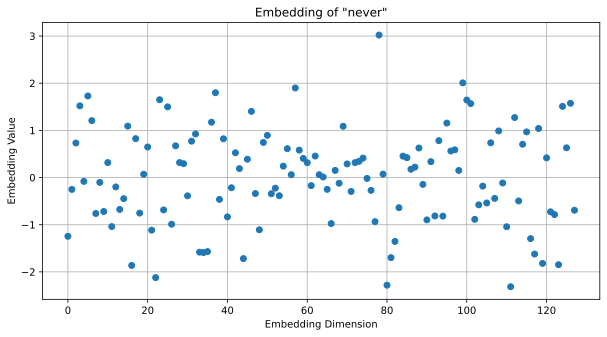

In [85]:
# View the Embedding for a random token.

randomToken = np.random.choice(vocabulary)

# Get the ID of the random token
token_id = token2id[randomToken]

# Get the embedding vector for the token without forward pass
embedding_vector = embedding_layer.weight.detach()[token2id[randomToken],:]

# Convert to numpy for plotting
embedding_values = embedding_vector.numpy()

# Plot the embedding vector as unconnected dots
plt.figure(figsize=(10, 5))
plt.plot(embedding_values, 'o')
plt.xlabel('Embedding Dimension')
plt.ylabel('Embedding Value')
plt.title(f'Embedding of "{randomToken}"')
plt.grid(True)
plt.show()

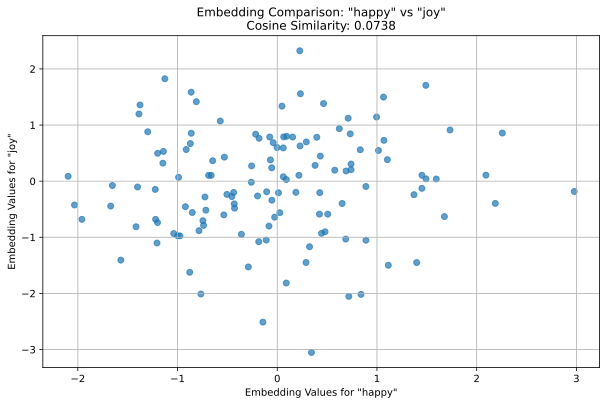

In [86]:
# View the Embedding for 2 semantically close tokens.
token_1 = "happy"
token_2 = "joy"

embedding_vector_1 = embedding_layer.weight.detach()[token2id[token_1],:]
embedding_vector_2 = embedding_layer.weight.detach()[token2id[token_2],:]

# cosine similarity
cosine_similarity = torch.dot(embedding_vector_1, embedding_vector_2) / (torch.norm(embedding_vector_1) * torch.norm(embedding_vector_2))


# Plotting embedding_vector_1 as x and embedding_vector_2 as y
plt.figure(figsize=(10, 6))
plt.scatter(embedding_vector_1.numpy(), embedding_vector_2.numpy(), alpha=0.7)
plt.xlabel(f'Embedding Values for "{token_1}"')
plt.ylabel(f'Embedding Values for "{token_2}"')
plt.title(f'Embedding Comparison: "{token_1}" vs "{token_2}"\nCosine Similarity: {cosine_similarity:.4f}')
plt.grid(True)
plt.show()

# [3] 🔷 Define the Model

In [87]:
class EmbeddingModel(nn.Module):
  def __init__(self, vocabulary_size, embedding_dimension, context_window_size):
    super(EmbeddingModel, self).__init__()

    # embedding layer
    # Embedding layer: Maps word indices to dense vectors.
    self.embedding_layer = nn.Embedding(vocabulary_size, embedding_dimension)
    # hidden layer
    # Hidden layer: Projects flattened context to hidden dimension.
    self.hidden_layer = nn.Linear(context_window_size * embedding_dimension,256)
    # output layer
    # Output layer: Projects hidden state to vocabulary size (logits).
    self.output_layer = nn.Linear(256, vocabulary_size)

  @override
  def forward(self, inputs):
    # Apply embedding layer to inputs
    # 1. Look up embeddings for context words.
    embedded_inputs = self.embedding_layer(inputs)
    # Flatten the embedded inputs: (batch_size, context_window_size * embedding_dimension)
    # This effectively concatenates the vectors of the context words.
    # [batch, n, emb_dim] -> [batch, n * emb_dim]
    # 2. Flatten/Concatenate embeddings: (Batch, Context * EmbDim).
    flattened_inputs = embedded_inputs.view(embedded_inputs.size(0), -1)

    # Pass through hidden layer with ReLU activation
    # This layer learns non-linear interactions between the context words.
    # 3. Apply non-linear activation (ReLU).
    hidden_output = F.relu(self.hidden_layer(flattened_inputs))

    # Pass through output layer
    # 4. Compute logits for the next word.
    output = self.output_layer(hidden_output)
    # Apply log_softmax to the output for NLLLoss
    log_probs = F.log_softmax(output, dim=1)
    return log_probs

model = EmbeddingModel(
    vocabulary_size=vocabulary_size,
    embedding_dimension=embedding_dimension,
    context_window_size=6,
)
model

EmbeddingModel(
  (embedding_layer): Embedding(27991, 128)
  (hidden_layer): Linear(in_features=768, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=27991, bias=True)
)

In [88]:
# Test the model with 1st batch of dataset
first_batch_inputs, first_batch_targets = next(iter(dataloader))

# The model predicts one next word for each input sequence in the batch.
# We get the log-probabilities for the first sequence in the batch, find the token ID
# with the highest probability (argmax), and convert it to a Python scalar (.item()).
predicted_token_id_for_first_input = model(first_batch_inputs)[0].argmax().item()

# Corrected printing for inputs: Iterate over individual token IDs within the first sequence
print(f'** Inputs (first sequence): {[id2Token[token_id.item()] for token_id in first_batch_inputs[0]]}')

# Corrected printing for targets: Iterate over individual token IDs within the first target sequence
# (Note: The model currently predicts a single word, while the target is a sequence of 6 words.)
print(f'** Targets (first sequence): {[id2Token[token_id.item()] for token_id in first_batch_targets[0]]}')

# Corrected printing for outputs: predicted_token_id_for_first_input is already a scalar
print(f'** Predicted Output (for first input sequence): {id2Token[predicted_token_id_for_first_input]}')

** Inputs (first sequence): ['lines', 'from', 'the', 'ode', 'to', 'nightingale']
** Targets (first sequence): ['from', 'the', 'ode', 'to', 'nightingale', 'flow']
** Predicted Output (for first input sequence): rowson


In [89]:
summary(model, input_data=first_batch_inputs, verbose=1, col_names=("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
EmbeddingModel                           [2, 6]                    [2, 27991]                --
├─Embedding: 1-1                         [2, 6]                    [2, 6, 128]               3,582,848
├─Linear: 1-2                            [2, 768]                  [2, 256]                  196,864
├─Linear: 1-3                            [2, 256]                  [2, 27991]                7,193,687
Total params: 10,973,399
Trainable params: 10,973,399
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 21.95
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 43.89
Estimated Total Size (MB): 44.36


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
EmbeddingModel                           [2, 6]                    [2, 27991]                --
├─Embedding: 1-1                         [2, 6]                    [2, 6, 128]               3,582,848
├─Linear: 1-2                            [2, 768]                  [2, 256]                  196,864
├─Linear: 1-3                            [2, 256]                  [2, 27991]                7,193,687
Total params: 10,973,399
Trainable params: 10,973,399
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 21.95
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 43.89
Estimated Total Size (MB): 44.36

# [4] 🏃 Model Training

#### ⛑ Some pre-work befor training...

In [90]:
# Update the DataLoader batch size to 32
batch_size = 32

dataloader = DataLoader(
      wiki_text_dataset,
      batch_size=batch_size,
      shuffle=True,   # shuffle each epoch
      drop_last=True, # drop incomplete batch
    )

In [91]:
# Create a new model instance
model = EmbeddingModel(
    vocabulary_size=vocabulary_size,
    embedding_dimension=embedding_dimension,
    context_window_size=6,
)

In [92]:
# Switch to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = model.to(device)

Using device: cuda


In [93]:
# Define the loss function for the model.
# nn.NLLLoss (Negative Log-Likelihood Loss) is typically used for multi-class classification tasks
# when the model's output provides log-probabilities (as our EmbeddingModel does using F.log_softmax).
# It measures the performance of a classification model where targets are provided as class indices.
loss_func = nn.NLLLoss().to(device)

# Define the optimizer, which is responsible for updating the model's parameters (weights and biases)
# to minimize the loss function during the training process.
# torch.optim.AdamW is an advanced variant of the Adam optimizer that includes 'Weight Decay'.
# 'Weight Decay' is a regularization technique (L2 regularization) that helps prevent overfitting
# by penalizing large weights, encouraging the model to learn more generalizable patterns.
optimizer = torch.optim.AdamW(
    model.parameters(), # This argument tells the optimizer which parameters (weights and biases) of the model to update.
    lr=0.001,           # 'lr' stands for learning rate.
    weight_decay=0.01   # 'weight_decay' is the strength of the L2 regularization. A higher value will penalize large weights more aggressively.
)

In [94]:
before_training_embedding_matrix = model.embedding_layer.weight.detach().clone()

#### 🛫 Train the model

In [95]:
def trainModel(model, epochs=15):
    """
    Trains the given PyTorch model for a specified number of epochs.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        epochs (int): The total number of training epochs. Defaults to 15.

    Returns:
        tuple: A tuple containing the trained model, and a NumPy array of average losses per epoch.
    """
    loss_per_epoch = np.zeros(epochs)

    for epoch in range(epochs):
        total_loss_current_epoch = 0

        for inputs, targets in dataloader:
            # Move inputs and targets to the device (GPU if available)
            inputs = inputs.to(device)
            # The model predicts the NEXT word after the context window.
            # 'targets' contains the sequence shifted by 1: [w_{t+1}, ..., w_{t+n}]
            # The input was [w_t, ..., w_{t+n-1}]
            # We want to predict w_{t+n}, which is the LAST element of the target sequence.
            targets_single_word = targets[:, -1].to(device)

            # Zero the gradients before running the backward pass
            # Clear previous gradients.
            optimizer.zero_grad()

            # Forward pass: compute the model output
            outputs = model(inputs)

            # Compute the loss
            loss = loss_func(outputs, targets_single_word)

            # Backward pass: compute gradient of the loss with respect to model parameters
            # Compute gradients via backpropagation.
            loss.backward()

            # Perform a single optimization step
            # Update model parameters using gradients.
            optimizer.step()

            # Accumulate the loss
            total_loss_current_epoch += loss.item()

        # Calculate average loss for the epoch
        avg_loss_current_epoch = total_loss_current_epoch / len(dataloader)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss_current_epoch:.5f}')

        loss_per_epoch[epoch] = avg_loss_current_epoch

    return model, loss_per_epoch

In [96]:
model, loss_per_epoch = trainModel(model, epochs=15)

Epoch 1/15, Average Loss: 3.00720
Epoch 2/15, Average Loss: 0.60124
Epoch 3/15, Average Loss: 0.06926
Epoch 4/15, Average Loss: 0.00491
Epoch 5/15, Average Loss: 0.00596
Epoch 6/15, Average Loss: 0.00283
Epoch 7/15, Average Loss: 0.00203
Epoch 8/15, Average Loss: 0.00129
Epoch 9/15, Average Loss: 0.00142
Epoch 10/15, Average Loss: 0.00101
Epoch 11/15, Average Loss: 0.00067
Epoch 12/15, Average Loss: 0.00049
Epoch 13/15, Average Loss: 0.00053
Epoch 14/15, Average Loss: 0.00019
Epoch 15/15, Average Loss: 0.00004


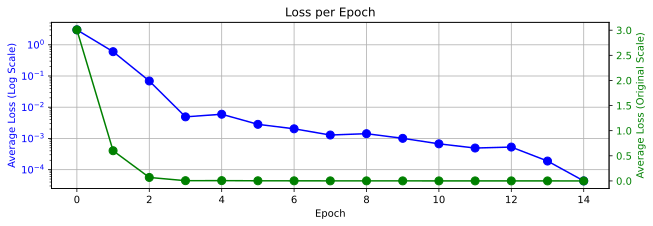

In [97]:
# Plot the loss per epoch with dual Y-axes
fig, ax1 = plt.subplots(figsize=(10, 3))

# Primary Y-axis (logarithmic scale)
ax1.plot(loss_per_epoch, marker='o', linestyle='-', markersize=8, color='blue')
ax1.set_title('Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss (Log Scale)', color='blue')
ax1.set_yscale('log')
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary Y-axis (linear scale)
ax2 = ax1.twinx() # Create a second axes that shares the same x-axis
ax2.plot(loss_per_epoch, marker='o', linestyle='-', markersize=8, color='green')
ax2.set_ylabel('Average Loss (Original Scale)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.ticklabel_format(axis='y', style='plain')

plt.show()

In [98]:
after_training_embedding_matrix = model.embedding_layer.weight.detach().clone()

# [5] 🧪 Embedding Evaluation

#### 👓 Cosine Similarity for token pairs

In [106]:
token_1 = "happy"
token_2 = "joy"
token_3 = "sad"
token_4 = "book"

def cosine_similarity(embedding_vec_1, embedding_vec_2):
    return torch.dot(embedding_vec_1, embedding_vec_2) / (torch.norm(embedding_vec_1) * torch.norm(embedding_vec_2))

In [107]:
# Get embedding vectors before training
embedding_vector_1_before = before_training_embedding_matrix[token2id[token_1],:]
embedding_vector_2_before = before_training_embedding_matrix[token2id[token_2],:]
embedding_vector_3_before = before_training_embedding_matrix[token2id[token_3],:]
embedding_vector_4_before = before_training_embedding_matrix[token2id[token_4],:]

# Calculate cosine similarity before training
cosine_similarity_before_1_2 = cosine_similarity(embedding_vector_1_before, embedding_vector_2_before)
cosine_similarity_before_1_3 = cosine_similarity(embedding_vector_1_before, embedding_vector_3_before)
cosine_similarity_before_1_4 = cosine_similarity(embedding_vector_1_before, embedding_vector_4_before)

# Get embedding vectors after training
embedding_vector_1_after = after_training_embedding_matrix[token2id[token_1],:]
embedding_vector_2_after = after_training_embedding_matrix[token2id[token_2],:]
embedding_vector_3_after = after_training_embedding_matrix[token2id[token_3],:]
embedding_vector_4_after = after_training_embedding_matrix[token2id[token_4],:]

# Calculate cosine similarity after training
cosine_similarity_after_1_2 = cosine_similarity(embedding_vector_1_after, embedding_vector_2_after)
cosine_similarity_after_1_3 = cosine_similarity(embedding_vector_1_after, embedding_vector_3_after)
cosine_similarity_after_1_4 = cosine_similarity(embedding_vector_1_after, embedding_vector_4_after)

# Print the results
print(f"Cosine Similarity between ['{token_1}'] and ['{token_2}']: \n\t*Before* training: {cosine_similarity_before_1_2.item():.4f}, *After* training: {cosine_similarity_after_1_2.item():.4f}\n")
print(f"Cosine Similarity between ['{token_1}'] and ['{token_3}']: \n\t*Before* training: {cosine_similarity_before_1_3.item():.4f}, *After* training: {cosine_similarity_after_1_3.item():.4f}\n")
print(f"Cosine Similarity between ['{token_1}'] and ['{token_4}']: \n\t*Before* training: {cosine_similarity_before_1_4.item():.4f}, *After* training: {cosine_similarity_after_1_4.item():.4f}\n")

Cosine Similarity between ['happy'] and ['joy']: 
	*Before* training: 0.0296, *After* training: 0.0486

Cosine Similarity between ['happy'] and ['sad']: 
	*Before* training: -0.0592, *After* training: -0.0088

Cosine Similarity between ['happy'] and ['book']: 
	*Before* training: -0.0425, *After* training: -0.0219



#### 👓 Embedding vector for a token

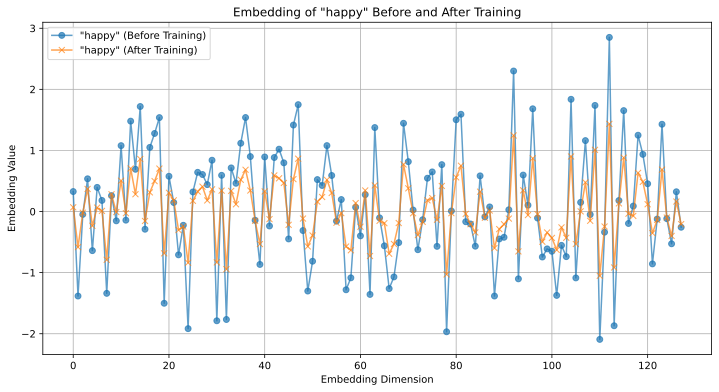

In [101]:
token_to_plot = "happy"

# Get embedding vectors for the chosen token
embedding_vector_before = before_training_embedding_matrix[token2id[token_to_plot],:]
embedding_vector_after = after_training_embedding_matrix[token2id[token_to_plot],:]

# Convert to numpy for plotting
embedding_values_before = embedding_vector_before.cpu().numpy()
embedding_values_after = embedding_vector_after.cpu().numpy()

# Plot the embedding vectors
plt.figure(figsize=(12, 6))
plt.plot(embedding_values_before, 'o-', label=f'"{token_to_plot}" (Before Training)', alpha=0.7)
plt.plot(embedding_values_after, 'x-', label=f'"{token_to_plot}" (After Training)', alpha=0.7)

plt.xlabel('Embedding Dimension')
plt.ylabel('Embedding Value')
plt.title(f'Embedding of "{token_to_plot}" Before and After Training')
plt.legend()
plt.grid(True)
plt.show()